In [24]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support as score

In [25]:
from sklearn.datasets import load_breast_cancer

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def transform_target(y):
    '''
    Transforms targets in [1, 0] format to [1, -1]
    Input:
        - y: Array of targets in [1, 0] form
    Output:
        - Array of targets in [1, -1] form
    '''

    return np.array([-1 if i == 0 else i for i in y])

def calculate_step_size_start(X, lambda_penalty):
    '''
    Calculates and uses Lipschitz constant to estimate
    the best starting step size for gradient descent.
    Input:
        - X: Feature records
        - lambda_penalty: Lambda value for regularization
    Output:
        - 1 / Lipschitz constant estimate
    '''

    n = X.shape[0]
    eigen_values, eigen_vectors = np.linalg.eigh(1/n * np.dot(X.T, X))
    L = np.max(eigen_values) + lambda_penalty

    return 1 / L

def computegrad(X, y, beta, lambda_penalty):
    '''
    Computes the gradient of the l2 regularized logistic regression objective function at beta
    using global X and y values from dataset.
    Input:
        - X: Training data
        - y: Training targets
        - beta: Weight Vector
        - lambda_penalty: Regularization term
    Output:
        - Gracient of Regularized logistic regression objective function at beta
    '''

    n = X.shape[0]

    return -1/n * np.sum(y * X.T / (1 + np.exp(y*np.dot(X, beta))), axis=1) + 2*lambda_penalty*beta

def backtracking(X, y, beta, lambda_penalty, t, alpha=0.5, gamma=0.8):
    '''
    Perform backtracking line search.
    Input:
      - X: Training data
      - y: Training targets
      - beta: Current point
      - lambda_penalty: Penalty value to apply in gradient of cost function
      - t: Starting (maximum) step size
      - alpha: Constant used to define sufficient decrease condition
      - gamma: Rate at which we decrease t if the previous t doesn't work
    Output:
      - t: Step size to use
    '''

    grad_beta = computegrad(X=X, y=y, beta=beta, lambda_penalty=lambda_penalty)
    norm_grad_beta = np.linalg.norm(grad_beta)

    while (obj(X=X, y=y, beta=beta - t*grad_beta, lambda_penalty=lambda_penalty) >\
           obj(X=X, y=y, beta=beta, lambda_penalty=lambda_penalty) - alpha*t*norm_grad_beta**2):

        t *= gamma

    return t

def obj(X, y, beta, lambda_penalty):
    '''
    Calculates the l2 regularized logistic regression objective function at beta
       using global X and y values from dataset.
    Input:
        - X: Training data
        - y: Training targets
        - beta: Weight Vector
        - lambda_penalty: Regularization term
    Output:
        - Regularized logistic regression objective function at beta
    '''

    n = X.shape[0]

    return 1/n * np.sum(np.log(1 + np.exp(-y * np.dot(X, beta)))) + lambda_penalty*np.linalg.norm(beta)**2

def fastgradalgo(X, y, lambda_penalty, t_init, eps=0.001, bt=0, v=0):
    '''
    Run gradient descent with backtracking to tune the step size.
    Input:
      - X: Training data
      - y: Training targets
      - lambda_penalty: Penalty value to apply in gradient of cost function
      - t_init: Initial step size (a constant)
      - eps: Value for convergence criterion for the the norm of the gradient
      - bt: Option to use backtracking line search for step size
      - v: Verbose param; prints objective value and norm of gradient
    Output:
      - theta_vals: 2D array of estimated theta's at each iteration,
                with the most recent values in the last row
    '''

    d = X.shape[1]

    beta = np.zeros(d)
    grad_beta = computegrad(X, y, beta, lambda_penalty)
    beta_vals = [beta]

    theta = np.zeros(d)
    grad_theta = computegrad(X, y, theta, lambda_penalty)
    theta_vals = [theta]

    i = 0
    while np.linalg.norm(grad_beta) > eps:

        if bt:
            t = backtracking(X, y, theta, t=t_init, lambda_penalty=lambda_penalty)
        else:
            t = t_init

        beta = theta - t*grad_theta
        theta = beta + i/(i+3) * (beta - beta_vals[-1])

        if v:
            print('Objective at theta: {}'.format(obj(X, y, theta, lambda_penalty)))
            print('Norm of gradient: {}'.format(np.linalg.norm(grad_theta)))

        beta_vals.append(beta)
        theta_vals.append(theta)

        grad_beta = computegrad(X, y, beta, lambda_penalty)
        grad_theta = computegrad(X, y, theta, lambda_penalty)
        i += 1

    return np.array(beta_vals)

def l2_log_reg(X, y, lambda_penalty, eps=0.001, v=0):
    '''
    Uses Lipschitz constant estimage to calculate optimal starting step size,
    then calls the fastgradalgo function to minimize the l2 regularized logistic
    regression object function with the fast gradient descent method using
    backtracking to update the step size at each iteration.  Returns the
    regression coefficents from each iteration of gradient descent.
    Run gradient descent with backtracking to tune the step size.
    Input:
      - X: Training data
      - y: Training targets
      - lambda_penalty: Penalty value to apply in gradient of cost function
      - eps: Value for convergence criterion for the the norm of the gradient
      - v: Verbose param; prints objective value and norm of gradient
    Output:
      - beta_vals: Estimated beta coefficents at each iteration,
                with the most recent values last.
    '''

    t_init = calculate_step_size_start(X, lambda_penalty=lambda_penalty)
    beta_vals = fastgradalgo(X, y, lambda_penalty, t_init, eps=eps, bt=1, v=v)

    return beta_vals


def predict(beta, X, threshold=0.5):
    '''
    Generates a logistic regression prediction given beta and X.
    Input:
        - beta: Learned weight vector
        - X: Array of records for which to generate predictions
        - threshold: Cut predictions such that above threshold => 1; below => -1
    Output:
        - Array of predictions
    '''

    scores = 1 / (1 + np.exp(-np.dot(X, beta)))
    return np.array([1 if i > threshold else -1 for i in scores])

def predict_all(beta_vals, X):
    '''
    Generates predictions for many beta values.
    Input:
        - beta_vals: Array of array of beta values
        - X: Array of array of records for which to generate predictions
    Output:
        - Array of array of predictions
    '''

    return np.array([predict(beta, X) for beta in beta_vals])

def error(pred, y):
    '''
    Calculates misclassification_error.
    Input:
        - pred: Array of predicted values
        - y: Array of target values
    Output:
        - Mean error
    '''

    return 1 - np.mean(pred == y)

def errors(pred_vals, y):
    '''
    Calculate missclassification error for many predictions.
    Input:
        - pred_vals: Array of array of predictions
        - y: Target labels
    Output:
        - Array of errors for each prediction
    '''

    return np.array([error(pred, y) for pred in pred_vals])

def plot_objective_values(X, y, beta_vals, lambda_penalty):
    '''
    Plot the convergence in terms of the function values and the gradients
    Input:
      - X: training data
      - y: training targets
      - beta_vals: Values the gradient descent algorithm stepped to
      - lambda_penalty: Penalty value to apply in gradient of cost function
    '''

    plt.clf()
    plt.plot([obj(X, y, val, lambda_penalty) for val in beta_vals])

    plt.xlabel('Iteration')
    plt.ylabel('Objective value')

    plt.title('Function Value at Each Beta for Gradient Convergence', fontsize=16)
    plt.show()

def plot_errors(pred_vals1, pred_vals2, y1, y2, labels):
    '''
    Plot the misclassification error at each iteration of gradient descent
    for two sets of predictions and targets.
    Input:
      - pred_vals1: Values the gradient descent algorithm stepped to
      - pred_vals2: Values the gradient descent algorithm stepped to
      - y1: Target labels
      - y2: Target labels
      - labels: Labels for each line plotted
    '''

    error1 = errors(pred_vals1, y1)
    error2 = errors(pred_vals2, y2)

    plt.clf()
    plt.plot(error1, label=labels[0])
    plt.plot(error2, label=labels[1])
    plt.xlabel('Iteration')
    plt.ylabel('Misclassification Error')

    plt.title('Misclassification Error at Each Iteration of Gradient Descent', fontsize=16)
    plt.legend(loc='best')
    plt.show()


def to_df_with_class(X, y):
    '''
    High class function that takes a2D numpy array of records X
    and 1D array of targets y and returns a dataframe of records
    with a column of targets called class.
    Input:
        -X: 2D numpy array of records
        -y: 1D numpy array of targets
    Output:
        -df: Pandas dataframe of records with a column of targets called class
    '''

    df = pd.DataFrame(data=X[0:,0:],
                      index=[i for i in range(0, X.shape[0])],
                      columns=[str(i) for i in range(0, X.shape[1])])
    df['class'] = y

    return df

def k_random_splits(df, k):
    '''
    Divides a dataframe into K random subsets by row
    Input:
        -df: Pandas dataframe to split
        -k: Number of random splits to generate
    Output:
        - List of k dataframes
    '''

    df = df.sample(frac=1).reset_index(drop=True)

    n = df.shape[0]
    avg = n / k
    dfs = []
    last = 0.0

    while last < n:
        dfs.append(df.loc[int(last):int(last + avg),])
        last += avg

    return dfs

def k_fold_crossval(X, y, lambdas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], k=5, eps=0.001, v=0):
    '''
    For L2 Regularized Logistic Regression, computes the
    mean test errors on each fold for k folds
    according the the K-Fold Cross-Validation algorithm
    given data X, targets y, and lambda values to try for each fold,
    along with the specified k and the epsilon stopping criteria for
    training the regression model.
    Input:
      - X: training data
      - y: training targets
      - lambdas: list of penalty values to apply in gradient of cost function
      - k: number of folds
      - eps: value for convergence criterion for the the norm of the gradient
      - v: verbose param; prints objective value and norm of gradient
    Output:
      - mean_test_errors: list of mean misclassifciation error at each iteration
    '''

    mean_test_errors = []
    for l in lambdas:

        dfs = k_random_splits(to_df_with_class(X, y), k)
        test_errors =[]
        for i in range(0, k):

            test_df = dfs[i]

            dfs_copy = dfs.copy()
            del dfs_copy[i]
            train_df = pd.concat(dfs_copy)

            X_train, y_train = train_df.drop('class', 1).values, train_df['class'].values
            X_test, y_test = test_df.drop('class', 1).values, test_df['class'].values

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            t_init = calculate_step_size_start(X_train, lambda_penalty=l)
            betas = l2_log_reg(X, y, l, eps, v)

            pred = predict(betas[-1], X_test, threshold=0.5)
            test_error = error(pred, y_test)
            test_errors.append(test_error)

        mean_test_error = round(np.mean(test_errors), 5)
        mean_test_errors.append(mean_test_error)
        print('Lambda={} mean misclassification error on test sets: {}'.format(l, mean_test_error))

    return mean_test_errors

In [27]:
data = load_breast_cancer()
X = data.data
y = data.target
features = data.target_names

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [29]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_train = transform_target(y_train)
y_test = transform_target(y_test)

In [30]:
beta_vals = l2_log_reg(X_train, y_train, lambda_penalty=1.0, eps=0.001, v=0)

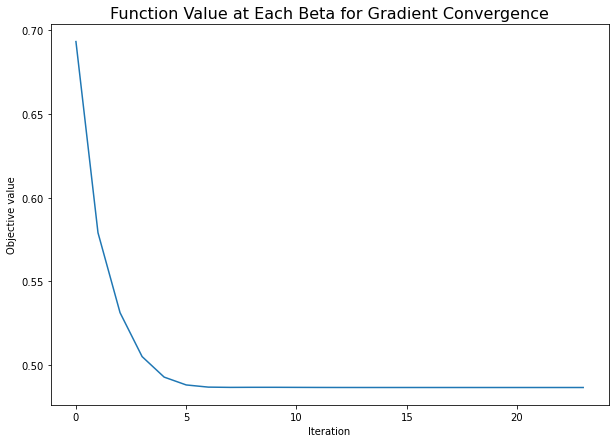

In [31]:
plot_objective_values(X_train, y_train, beta_vals, lambda_penalty=1.0)

In [32]:
train_pred_vals = predict_all(beta_vals, X_train)
test_pred_vals = predict_all(beta_vals, X_test)

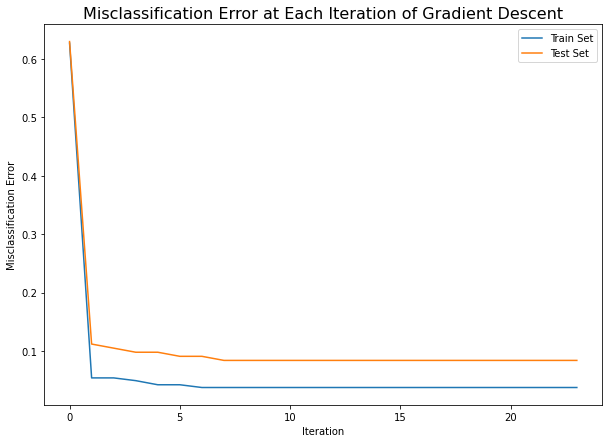

In [33]:
plot_errors(train_pred_vals, test_pred_vals, y_train, y_test, labels=['Train Set', 'Test Set'])

### Five Fold Cross Validation with Regularization

In [34]:
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
mean_test_errors = k_fold_crossval(X_train, y_train, lambdas, k=5, eps=0.001)

Lambda=0.001 mean misclassification error on test sets: 0.0093
Lambda=0.01 mean misclassification error on test sets: 0.01395
Lambda=0.1 mean misclassification error on test sets: 0.02558
Lambda=1 mean misclassification error on test sets: 0.03721
Lambda=10 mean misclassification error on test sets: 0.05116
Lambda=100 mean misclassification error on test sets: 0.04884
Lambda=1000 mean misclassification error on test sets: 0.05349


In [35]:
best_lambda = lambdas[np.argmin(mean_test_errors)]
print('Best lambda: {}'.format(best_lambda))

Best lambda: 0.001


In [36]:
beta_vals = l2_log_reg(X_train, y_train, lambda_penalty=best_lambda, eps=0.001, v=0)

In [37]:
train_pred_vals = predict_all(beta_vals, X_train)
test_pred_vals = predict_all(beta_vals, X_test)

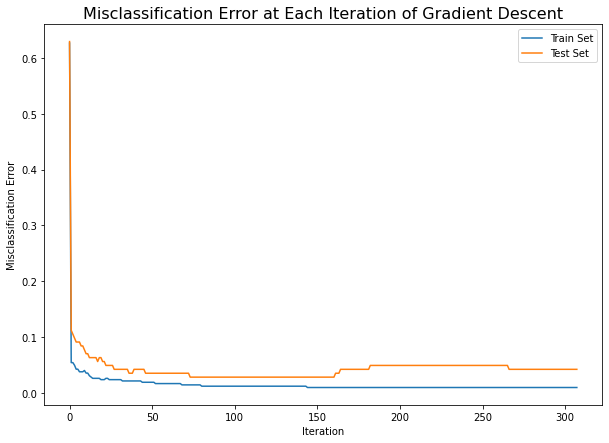

In [38]:
plot_errors(train_pred_vals, test_pred_vals, y_train, y_test, labels=['Train Set', 'Test Set'])

In [39]:
train_precision, train_recall, train_fscore, train_support = score(y_train, train_pred_vals[-1])
val_precision, val_recall, val_fscore, val_support = score(y_test, test_pred_vals[-1])

pr_df = pd.DataFrame({'Class': list(range(0, 2)),
                      'TrainPrecision': train_precision,
                      'TrainRecall': train_recall,
                      'ValidationPrecision': val_precision,
                      'ValidationRecall': val_recall})
pr_df

,Class,TrainPrecision,TrainRecall,ValidationPrecision,ValidationRecall
0,0,1.00000,0.974843,0.943396,0.943396
1,1,0.98524,1.000000,0.966667,0.966667


In [40]:
my_preds = predict(beta_vals[-1], X_test, threshold=0.5)
error(my_preds, y_test)

0.04195804195804198

### Confusion Matrix

Normalized confusion matrix
[[0.94339623 0.05660377]
 [0.03333333 0.96666667]]


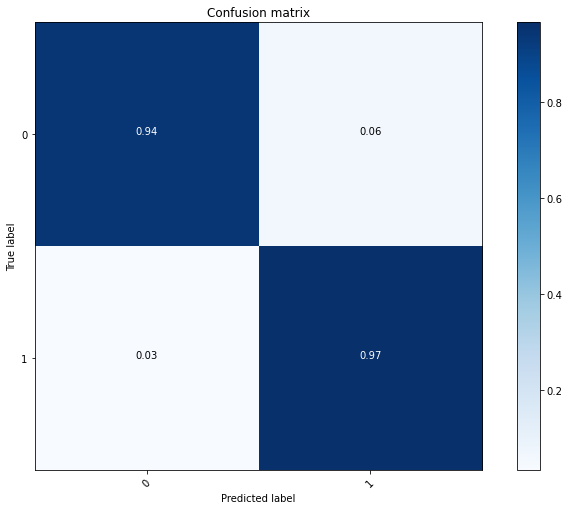

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
    
my_preds = predict(beta_vals[-1], X_test, threshold=0.5)   
cm = confusion_matrix(y_test, my_preds)
plot_confusion_matrix(cm, list(range(2))) 

### Comparison with scikit-learn

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(penalty='l2', solver='liblinear')
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

clf = GridSearchCV(estimator=estimator, cv=5, param_grid=param_grid)
clf = clf.fit(X, y)

results = clf.cv_results_
best_run = np.argmax(results['mean_test_score'])
best_c = results['params'][best_run]['C']
best_lambda = 1/best_c * 1/len(y_train) * 1/2
print('Best C: {}'.format(best_c))
print('Best lambda: {}'.format(best_lambda))

Best C: 5
Best lambda: 0.0002347417840375587


In [44]:
clf = LogisticRegression(penalty='l2', solver='liblinear', C=best_c, tol=0.001)
clf = clf.fit(X_train, y_train)

In [45]:
sklearn_preds = clf.predict(X_test)
error(sklearn_preds, y_test)

0.04895104895104896